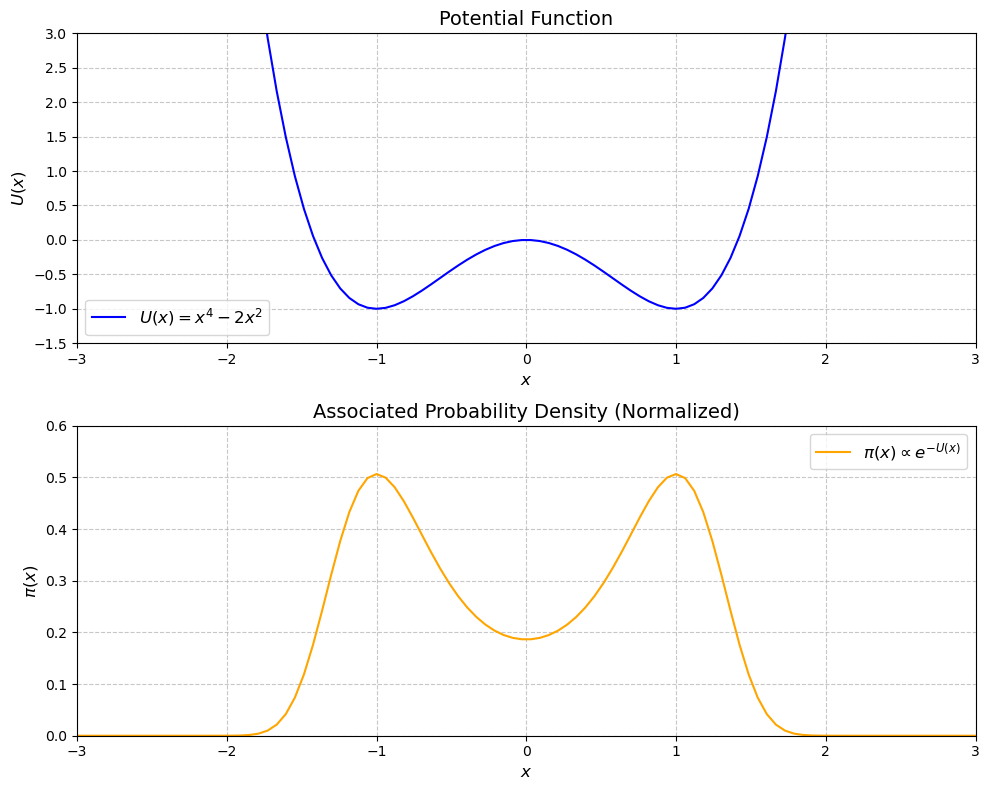

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

# Parameters for plotting
L = 3.0  # Domain size [-L, L]
N = 100  # Number of spatial grid points
x = np.linspace(-L, L, N)  # Spatial grid

# Potential function
def U(x):
    return x**4 - 2 * x**2

# Associated probability density (unnormalized)
def pi_unnormalized(x):
    return np.exp(-U(x))

# Normalize the probability density
pi = pi_unnormalized(x)
norm_constant = simpson(pi, x)
pi_normalized = pi / norm_constant

# Create figure
plt.figure(figsize=(10, 8))

# Plot potential
plt.subplot(2, 1, 1)
plt.plot(x, U(x), label='$U(x) = x^4 - 2x^2$', color='blue')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$U(x)$', fontsize=12)
plt.title('Potential Function', fontsize=14)
plt.xlim(-3, 3)
plt.ylim(-1.5, 3)  # U ranges from -1 (at x=±1) to ~9 at x=±3
plt.xticks(np.arange(-3, 4, 1), fontsize=10)
plt.yticks(np.arange(-1.5, 3.5, 0.5), fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot probability density
plt.subplot(2, 1, 2)
plt.plot(x, pi_normalized, label='$\pi(x) \propto e^{-U(x)}$', color='orange')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$\pi(x)$', fontsize=12)
plt.title('Associated Probability Density (Normalized)', fontsize=14)
plt.xlim(-3, 3)
plt.ylim(0, 0.6)  # pi peaks around 0.5 near x=±1
plt.xticks(np.arange(-3, 4, 1), fontsize=10)
plt.yticks(np.arange(0, 0.7, 0.1), fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

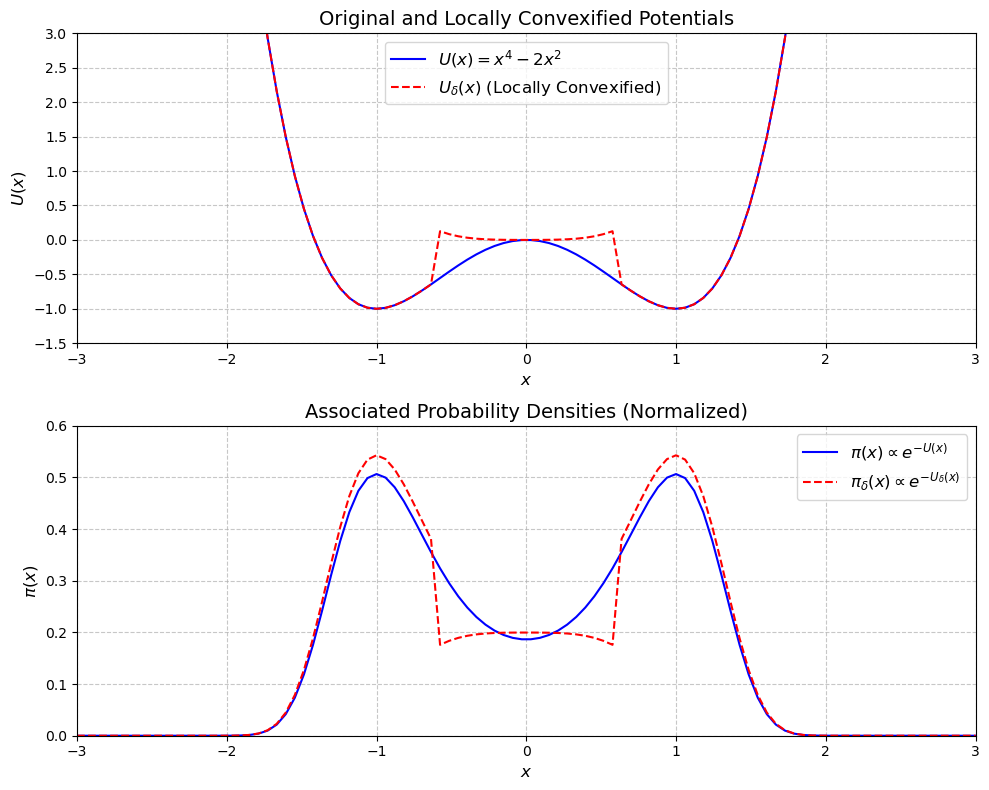

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

# Parameters
L = 3.0  # Domain size [-L, L]
N = 100  # Number of spatial grid points
x = np.linspace(-L, L, N)

# Original potential
def U(x):
    return x**4 - 2 * x**2

# Locally convexified potential
def U_delta(x):
    delta = 4.1  # Convexification parameter for [-0.6, 0.6]
    mask = (x >= -0.6) & (x <= 0.6)
    return np.where(mask, U(x) + 0.5 * delta * x**2, U(x))

# Probability densities (unnormalized)
def pi_unnormalized(x, U_func):
    return np.exp(-U_func(x))

# Normalize density
pi_orig = pi_unnormalized(x, U)
pi_orig /= simpson(pi_orig, x)
pi_delta = pi_unnormalized(x, U_delta)
pi_delta /= simpson(pi_delta, x)

# Plot
plt.figure(figsize=(10, 8))

# Plot potentials
plt.subplot(2, 1, 1)
plt.plot(x, U(x), label='$U(x) = x^4 - 2x^2$', color='blue')
plt.plot(x, U_delta(x), label='$U_{\delta}(x)$ (Locally Convexified)', color='red', linestyle='--')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$U(x)$', fontsize=12)
plt.title('Original and Locally Convexified Potentials', fontsize=14)
plt.xlim(-3, 3)
plt.ylim(-1.5, 3)
plt.xticks(np.arange(-3, 4, 1), fontsize=10)
plt.yticks(np.arange(-1.5, 3.5, 0.5), fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot densities
plt.subplot(2, 1, 2)
plt.plot(x, pi_orig, label='$\pi(x) \propto e^{-U(x)}$', color='blue')
plt.plot(x, pi_delta, label='$\pi_{\delta}(x) \propto e^{-U_{\delta}(x)}$', color='red', linestyle='--')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$\pi(x)$', fontsize=12)
plt.title('Associated Probability Densities (Normalized)', fontsize=14)
plt.xlim(-3, 3)
plt.ylim(0, 0.6)
plt.xticks(np.arange(-3, 4, 1), fontsize=10)
plt.yticks(np.arange(0, 0.7, 0.1), fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

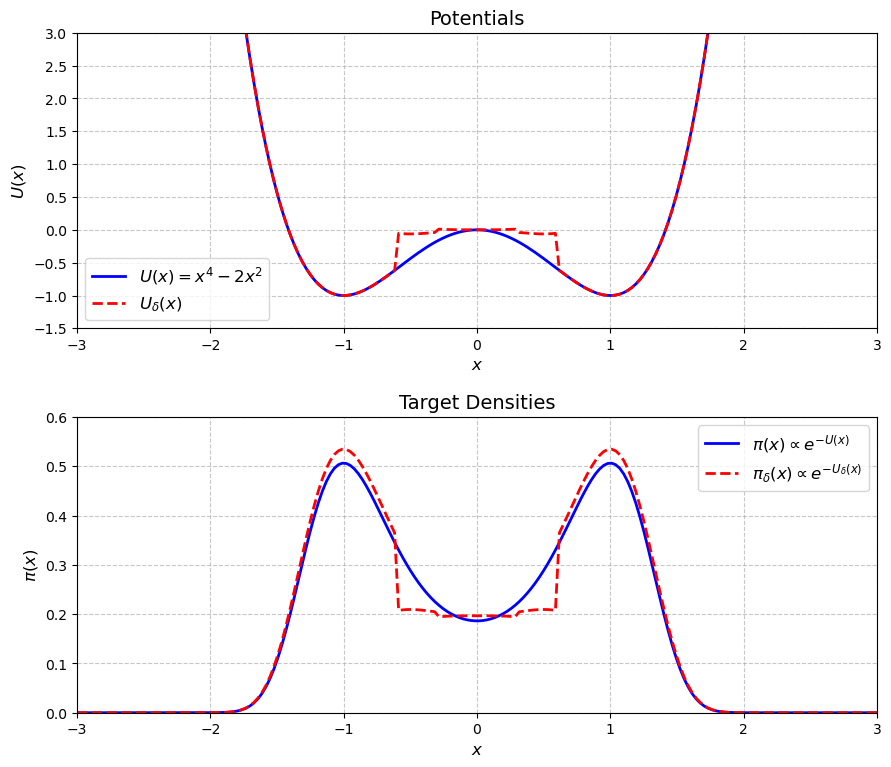

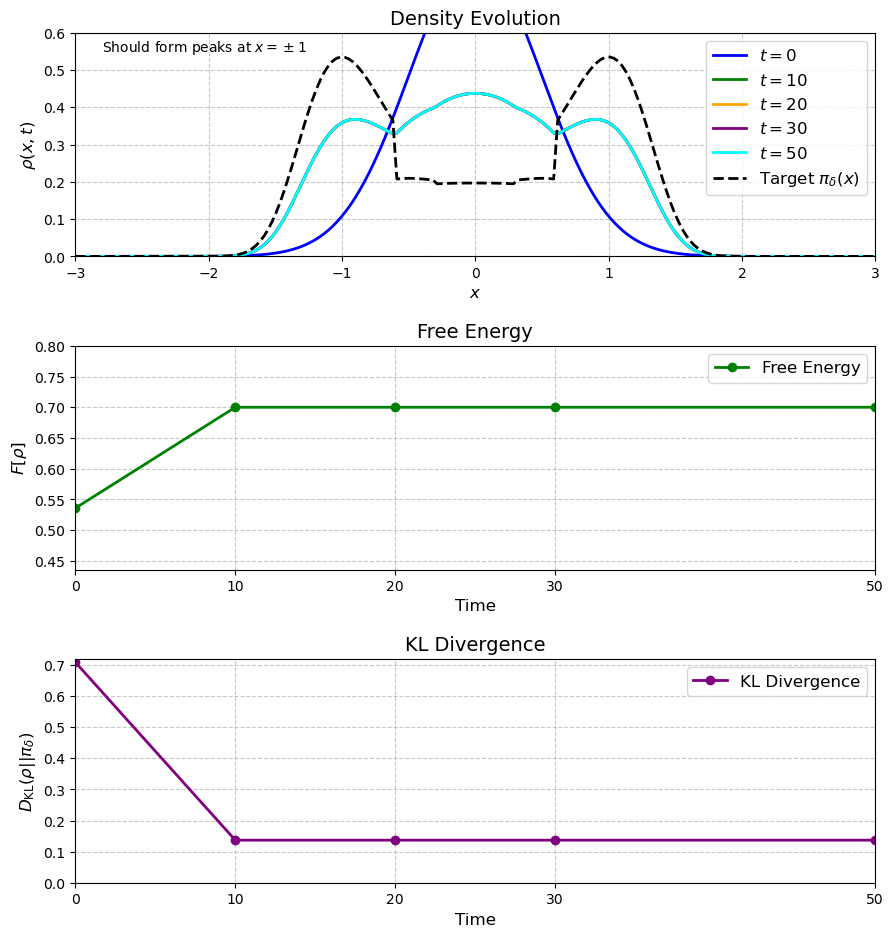

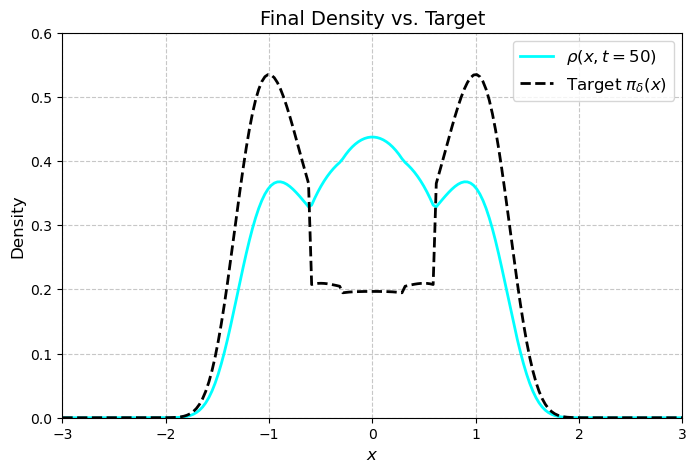

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Ensure Matplotlib uses mathtext correctly
plt.rc('text', usetex=False)

# Parameters
L = 3.0  # Domain size [-L, L]
N = 200  # Refined spatial grid
T = 50.0  # Extended total time
M = 10000  # Number of time steps
dx = 2 * L / (N - 1)  # Spatial step
dt = T / M  # Time step
x = np.linspace(-L, L, N)
beta = 1.0  # Match target distribution

# Original potential
def U(x):
    return x**4 - 2 * x**2

# Locally convexified potential (refined partition)
def U_delta(x):
    delta1 = 4.1  # For [-0.3, 0.3]
    delta2 = 3.0  # For [-0.6, -0.3) and (0.3, 0.6]
    delta3 = 0.0  # For [-3, -0.6) and (0.6, 3]
    mask1 = (x >= -0.3) & (x <= 0.3)
    mask2 = ((x >= -0.6) & (x < -0.3)) | ((x > 0.3) & (x <= 0.6))
    mask3 = (x < -0.6) | (x > 0.6)
    return np.where(mask1, U(x) + 0.5 * delta1 * x**2,
                    np.where(mask2, U(x) + 0.5 * delta2 * x**2, U(x)))

# Gradient of locally convexified potential
def grad_U_delta(x):
    grad_U = 4 * x**3 - 4 * x
    delta1 = 4.1
    delta2 = 3.0
    mask1 = (x >= -0.3) & (x <= 0.3)
    mask2 = ((x >= -0.6) & (x < -0.3)) | ((x > 0.3) & (x <= 0.6))
    return np.where(mask1, grad_U + delta1 * x,
                    np.where(mask2, grad_U + delta2 * x, grad_U))

# Probability density (unnormalized)
def pi_unnormalized(x, U_func):
    return np.exp(-beta * U_func(x))

# Normalize density
pi_orig = pi_unnormalized(x, U)
pi_orig /= simpson(pi_orig, x)
pi_delta = pi_unnormalized(x, U_delta)
pi_delta /= simpson(pi_delta, x)

# Free energy functional
def free_energy(rho, x, beta):
    rho_safe = np.maximum(rho, 1e-10)
    energy_term = simpson(rho * U_delta(x), x)
    entropy_term = simpson(rho * np.log(rho_safe), x)
    return energy_term - (1.0 / beta) * entropy_term

# KL divergence
def kl_divergence(rho, pi):
    rho_safe = np.maximum(rho, 1e-10)
    pi_safe = np.maximum(pi, 1e-10)
    return simpson(rho_safe * np.log(rho_safe / pi_safe), x)

# Fokker-Planck implicit solver matrix with separate drift and diffusion
def build_fokker_planck_matrix(rho, x, beta, dt, dx):
    rho_safe = np.maximum(rho, 1e-10)
    grad_U = grad_U_delta(x)
    # Drift term: div(rho * grad U)
    drift = rho_safe * grad_U
    grad_drift = np.gradient(drift, dx, edge_order=2)
    # Diffusion term: (1/beta) * Laplacian
    diff_coeff = (1.0 / beta) / (dx**2)
    # Construct matrix
    main_diag = 1.0 + 2 * dt * diff_coeff * np.ones(N)
    off_diag_lower = -dt * diff_coeff * np.ones(N-1)
    off_diag_upper = -dt * diff_coeff * np.ones(N-1)
    # Adjust for drift term: div(rho * grad U)
    drift_term = dt * grad_drift / rho_safe
    main_diag -= drift_term
    # Zero-flux BCs
    main_diag[0] = 1.0 + dt * diff_coeff
    off_diag_upper[0] = -dt * diff_coeff
    main_diag[-1] = 1.0 + dt * diff_coeff
    off_diag_lower[-1] = -dt * diff_coeff
    A = diags([off_diag_lower, main_diag, off_diag_upper], [-1, 0, 1], shape=(N, N))
    return A.tocsr()

# Initial probability density (Gaussian)
rho0 = np.exp(-x**2 / 0.5) / np.sqrt(0.5 * np.pi)
rho0 /= simpson(rho0, x)

# Time evolution (implicit Euler)
rho = rho0.copy()
rho_history = []
F_history = []
kl_history = []
times = [0, 10, 20, 30, 50]  # Key time points
steps = [int(t * M / T) for t in times]

for t in range(M + 1):
    if t in steps:
        rho_history.append(rho.copy())
        F_history.append(free_energy(rho, x, beta))
        kl_history.append(kl_divergence(rho, pi_delta))
    A = build_fokker_planck_matrix(rho, x, beta, dt, dx)
    rho_new = spsolve(A, rho)
    rho_new = np.maximum(rho_new, 1e-10)
    # Small regularization to prevent spikes
    rho_new = 0.99 * rho_new + 0.01 * rho0 / simpson(rho0, x)
    rho_new /= simpson(rho_new, x)
    rho = rho_new

# Plotting
# Plot potentials and densities
plt.figure(figsize=(10, 8))
# Potentials
plt.subplot(2, 1, 1)
plt.plot(x, U(x), label=r'$U(x) = x^4 - 2x^2$', color='blue', linewidth=2)
plt.plot(x, U_delta(x), label=r'$U_{\delta}(x)$', color='red', linestyle='--', linewidth=2)
plt.xlabel(r'$x$', fontsize=12)
plt.ylabel(r'$U(x)$', fontsize=12)
plt.title('Potentials', fontsize=14)
plt.xlim(-3, 3)
plt.ylim(-1.5, 3)
plt.xticks(np.arange(-3, 4, 1), fontsize=10)
plt.yticks(np.arange(-1.5, 3.5, 0.5), fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# Densities
plt.subplot(2, 1, 2)
plt.plot(x, pi_orig, label=r'$\pi(x) \propto e^{-U(x)}$', color='blue', linewidth=2)
plt.plot(x, pi_delta, label=r'$\pi_{\delta}(x) \propto e^{-U_{\delta}(x)}$', color='red', linestyle='--', linewidth=2)
plt.xlabel(r'$x$', fontsize=12)
plt.ylabel(r'$\pi(x)$', fontsize=12)
plt.title('Target Densities', fontsize=14)
plt.xlim(-3, 3)
plt.ylim(0, 0.6)
plt.xticks(np.arange(-3, 4, 1), fontsize=10)
plt.yticks(np.arange(0, 0.7, 0.1), fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1, hspace=0.3)
plt.show()

# Plot sampling results
plt.figure(figsize=(10, 10))
# Density evolution
plt.subplot(3, 1, 1)
colors = ['blue', 'green', 'orange', 'purple', 'cyan']
for i, (rho_t, t) in enumerate(zip(rho_history, times)):
    plt.plot(x, rho_t, label=f'$t={t}$', color=colors[i], linewidth=2)
plt.plot(x, pi_delta, 'k--', label=r'Target $\pi_{\delta}(x)$', linewidth=2)
plt.xlabel(r'$x$', fontsize=12)
plt.ylabel(r'$\rho(x, t)$', fontsize=12)
plt.title('Density Evolution', fontsize=14)
plt.xlim(-3, 3)
plt.ylim(0, 0.6)
plt.xticks(np.arange(-3, 4, 1), fontsize=10)
plt.yticks(np.arange(0, 0.7, 0.1), fontsize=10)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.text(-2.8, 0.55, 'Should form peaks at $x=\\pm 1$', fontsize=10, color='black')
# Free energy
plt.subplot(3, 1, 2)
plt.plot(times, F_history, '-o', label='Free Energy', color='green', linewidth=2)
plt.xlabel('Time', fontsize=12)
plt.ylabel(r'$F[\rho]$', fontsize=12)
plt.title('Free Energy', fontsize=14)
plt.xlim(0, T)
plt.ylim(min(F_history) - 0.1, max(F_history) + 0.1)
plt.xticks(times, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# KL divergence
plt.subplot(3, 1, 3)
plt.plot(times, kl_history, '-o', label='KL Divergence', color='purple', linewidth=2)
plt.xlabel('Time', fontsize=12)
plt.ylabel(r'$D_{\mathrm{KL}}(\rho || \pi_{\delta})$', fontsize=12)
plt.title('KL Divergence', fontsize=14)
plt.xlim(0, T)
plt.ylim(0, max(kl_history) + 0.01)
plt.xticks(times, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1, hspace=0.4)
plt.show()

# Final density comparison
plt.figure(figsize=(8, 5))
plt.plot(x, rho_history[-1], label=r'$\rho(x, t=50)$', color='cyan', linewidth=2)
plt.plot(x, pi_delta, 'k--', label=r'Target $\pi_{\delta}(x)$', linewidth=2)
plt.xlabel(r'$x$', fontsize=12)
plt.ylabel(r'Density', fontsize=12)
plt.title('Final Density vs. Target', fontsize=14)
plt.xlim(-3, 3)
plt.ylim(0, 0.6)
plt.xticks(np.arange(-3, 4, 1), fontsize=10)
plt.yticks(np.arange(0, 0.7, 0.1), fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Step-by-Step Guide to Implementation

#### Step 1: Set Up the Environment and Parameters
- **Objective**: Define the computational domain, numerical parameters, and constants.
- **Details**:
  - **Domain**: Use \( x \in [-L, L] \), with \( L = 3.0 \), to cover the region where \( U(x) = x^4 - 2x^2 \) has minima at \( x = \pm 1 \).
  - **Spatial Grid**: Choose \( N = 200 \) points for a refined grid, giving spatial step \( dx = \frac{2L}{N-1} \approx 0.03 \).
  - **Time**: Set total time \( T = 50.0 \) to allow sufficient convergence, with \( M = 10000 \) time steps, so \( dt = T/M = 0.005 \).
  - **Inverse Temperature**: Set \( \beta = 1.0 \), so the target \( \pi_{\delta}(x) \propto e^{-U_{\delta}(x)} \), aligning with the document’s convention.
  - **Imports**: Use NumPy for numerical computations, Matplotlib for plotting, SciPy for integration (`simpson`), sparse matrices (`diags`), and linear solvers (`spsolve`).

#### Step 2: Define the Potential Functions
- **Objective**: Define the original potential \( U(x) \) and its locally convexified version \( U_{\delta}(x) \), along with their gradients.
- **Details**:
  - **Original Potential \( U(x) \)**:
    \[
    U(x) = x^4 - 2x^2
    \]
    This has minima at \( x = \pm 1 \), but it’s non-convex (negative curvature at \( x = 0 \)).
  - **Locally Convexified Potential \( U_{\delta}(x) \)**:
    - Use the refined partition from the document:
      - For \( x \in [-0.3, 0.3] \), add \( \frac{1}{2} \delta_1 x^2 \) with \( \delta_1 = 4.1 \).
      - For \( x \in [-0.6, -0.3) \cup (0.3, 0.6] \), add \( \frac{1}{2} \delta_2 x^2 \) with \( \delta_2 = 3.0 \).
      - For \( x \in [-3, -0.6) \cup (0.6, 3] \), \( \delta_3 = 0.0 \).
    - This ensures \( U_{\delta}(x) \) is convex in each subdomain, facilitating convergence (per Proposition 3).
  - **Gradient \( \nabla U_{\delta}(x) \)**:
    - Compute analytically: \( \nabla U(x) = 4x^3 - 4x \), then add \( \delta_i x \) in the respective regions.

#### Step 3: Compute the Target Distribution
- **Objective**: Calculate the target distributions \( \pi(x) \propto e^{-U(x)} \) and \( \pi_{\delta}(x) \propto e^{-U_{\delta}(x)} \).
- **Details**:
  - **Unnormalized Densities**:
    \[
    \pi_{\text{unnorm}}(x) = e^{-\beta U(x)}, \quad \pi_{\delta, \text{unnorm}}(x) = e^{-\beta U_{\delta}(x)}
    \]
    With \( \beta = 1.0 \), this simplifies to \( e^{-U(x)} \) and \( e^{-U_{\delta}(x)} \).
  - **Normalization**:
    - Use numerical integration (SciPy’s `simpson`) to compute the normalization constant:
      \[
      Z = \int_{-L}^{L} e^{-\beta U_{\delta}(x)} \, dx
      \]
      \[
      \pi_{\delta}(x) = \frac{e^{-\beta U_{\delta}(x)}}{Z}
      \]
    - Repeat for \( \pi(x) \).

#### Step 4: Define the Free Energy Functional
- **Objective**: Implement the free energy \( \mathcal{F}[\rho] \) to drive the dynamics.
- **Details**:
  - The corrected free energy is:
    \[
    \mathcal{F}[\rho] = \int U_{\delta}(x) \rho(x, t) \, dx - \frac{1}{\beta} \int \rho(x, t) \ln \rho(x, t) \, dx
    \]
  - **Energy Term**: \( \int U_{\delta}(x) \rho \, dx \), computed via `simpson`.
  - **Entropy Term**: \( -\int \rho \ln \rho \, dx \), scaled by \( \frac{1}{\beta} \). Use a safeguard \( \rho_{\text{safe}} = \max(\rho, 10^{-10}) \) to avoid \( \ln 0 \).
  - This functional ensures \( \rho(x, t) \to \pi_{\delta}(x) \) as \( \mathcal{F}[\rho] \) is minimized.

#### Step 5: Implement the Fokker-Planck Equation
- **Objective**: Solve the Fokker-Planck equation to evolve \( \rho(x, t) \).
- **Details**:
  - The equation, derived from the free energy, is:
    \[
    \partial_t \rho = \nabla \cdot \left( \rho \nabla \frac{\delta \mathcal{F}}{\delta \rho} \right)
    \]
    where:
    \[
    \frac{\delta \mathcal{F}}{\delta \rho} = U_{\delta}(x) - \frac{1}{\beta} (\ln \rho + 1)
    \]
    \[
    \nabla \frac{\delta \mathcal{F}}{\delta \rho} = \nabla U_{\delta}(x) - \frac{1}{\beta} \frac{\nabla \rho}{\rho}
    \]
    So:
    \[
    \partial_t \rho = \nabla \cdot \left( \rho \nabla U_{\delta} - \frac{1}{\beta} \nabla \rho \right) = \nabla \cdot (\rho \nabla U_{\delta}) + \frac{1}{\beta} \Delta \rho
    \]
  - **Discretization**:
    - Use an implicit Euler scheme for stability: \( \rho^{n+1} = \rho^n + dt \left( \nabla \cdot (\rho \nabla U_{\delta}) + \frac{1}{\beta} \Delta \rho \right) \).
    - Construct a tridiagonal matrix for the implicit solver:
      - **Diffusion Term**: \( \frac{1}{\beta} \Delta \rho \), discretized as:
        \[
        \Delta \rho \approx \frac{\rho_{i+1} - 2\rho_i + \rho_{i-1}}{dx^2}
        \]
        Coefficient: \( \frac{1}{\beta} \frac{1}{dx^2} \).
      - **Drift Term**: \( \nabla \cdot (\rho \nabla U_{\delta}) \), compute \( \rho \nabla U_{\delta} \), then take the divergence via central differences.
      - **Zero-Flux Boundary Conditions**: At \( x = \pm L \), ensure \( J = \rho \nabla U_{\delta} - \frac{1}{\beta} \nabla \rho = 0 \), adjusting the matrix at the boundaries.
  - **Solve**: Use `spsolve` to solve the linear system \( A \rho^{n+1} = \rho^n \).

#### Step 6: Set Initial Condition and Evolve
- **Objective**: Initialize \( \rho(x, 0) \) and evolve it over time.
- **Details**:
  - **Initial Condition**: Use a Gaussian:
    \[
    \rho(x, 0) \propto e^{-x^2 / 0.5} / \sqrt{0.5 \pi}
    \]
    Normalize using `simpson`.
  - **Time Evolution**:
    - Loop over \( M \) time steps.
    - At each step, compute the matrix \( A \), solve for \( \rho_{\text{new}} \), and normalize.
    - Add a small regularization to prevent spikes:
      \[
      \rho_{\text{new}} = 0.99 \rho_{\text{new}} + 0.01 \rho_0
      \]
    - Save snapshots at key times (e.g., \( t = 0, 10, 20, 30, 50 \)).

#### Step 7: Monitor Convergence
- **Objective**: Track convergence to \( \pi_{\delta}(x) \) using metrics.
- **Details**:
  - **Free Energy**: Compute \( \mathcal{F}[\rho(t)] \) at each snapshot.
  - **KL Divergence**:
    \[
    D_{\mathrm{KL}}(\rho || \pi_{\delta}) = \int \rho \ln \left( \frac{\rho}{\pi_{\delta}} \right) \, dx
    \]
    Use safeguards for numerical stability.
  - Both should decrease, confirming convergence (per Proposition 3).

#### Step 8: Visualize Results
- **Objective**: Plot the results to assess convergence.
- **Details**:
  - **First Figure**: Potentials and target densities.
    - Plot \( U(x) \) and \( U_{\delta}(x) \), \( x: [-3, 3], y: [-1.5, 3] \).
    - Plot \( \pi(x) \) and \( \pi_{\delta}(x) \), \( x: [-3, 3], y: [0, 0.6] \).
  - **Second Figure**: Evolution and metrics.
    - **Density Evolution**: Plot \( \rho(x, t) \) at selected times, compare to \( \pi_{\delta}(x) \).
    - **Free Energy**: Plot \( \mathcal{F}[\rho(t)] \), should decrease.
    - **KL Divergence**: Plot \( D_{\mathrm{KL}} \), should approach zero.
  - **Third Figure**: Final comparison.
    - Plot \( \rho(x, t=50) \) vs. \( \pi_{\delta}(x) \), \( x: [-3, 3], y: [0, 0.6] \).
